# Demonstration of Instability in the Initial Calibration Algorithm

### In this notebook, we demonstrate the challenges encountered when testing the first version of our adaptive calibration algorithm. Specifically, we show how early miscalibration leads to runaway behavior in the uncertainty parameters `q_t` and `Q_t`, resulting in overly conservative intervals and unstable predictions.


In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "." or ".." depending on your structure

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.modules_that_didnt_workout.BCUC_calibrator import BCUC_Calibrator
from models.model_utils import params


In [13]:

!python ../observation_generation.py --dir_path "../observations" --format npz --n_steps 1000

Creating linear system...
[[0.0001]]

Generating observations for random_zeros_and_actions actions...
Generated 1001 observations
Observation shape: (1,)
Data saved as ../observations/observations_random_zeros_and_actions_for_Q0.0001_steps_1000.npz
Model parameters saved as ../observations/observations_random_zeros_and_actions_for_Q0.0001_steps_1000_params.json
Observation mean: [3.48952997]
Observation std: [2.02479217]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [109]:
#load 
data = np.load("../observations/first_person/observations_random_zeros_and_actions_for_Q0.0001_initialModel_0.0001.npz")
masked_observations = mask_observations(data['observations'])
actions = data['actions']

patient_1_model = LinearModel_Estimator(**params) #Q_initial = 0.1
print(f"Initial Q matrix: {patient_1_model.Q}")
print(f"wanted Q matrix: 0.0001")
calibrator = BCUC_Calibrator(patient_1_model)  # Note: Capital 'C' in Calibrator
patient_1_calibrated = calibrator.calibrate_model(masked_observations, actions)
boolFlag = patient_1_model is patient_1_calibrated

print(f"calibrated Q :{patient_1_calibrated.Q}")


Initial Q matrix: [[0.0001]]
wanted Q matrix: 0.0001
e_t:0, mean_error = 0.0
Computed eta: 0.06872114678651144, eta_max: 0.5
Max score: 0.6872114678651143
Updated Q : [[0.0001]], q: [2.]
Conditional distribution mean: [10.16505242], obs: [10.16505242], conditional variance: [[0.]]
e_t:0, mean_error = 0.0
Computed eta: 0.177685182244165, eta_max: 0.5
Max score: 1.7768518224416499
Updated Q : [[0.0001]], q: [2.]
Conditional distribution mean: [10.31813847], obs: [10.31813847], conditional variance: [[0.]]
e_t:0, mean_error = 0.0
Computed eta: 0.17996805483783468, eta_max: 0.5
Max score: 1.7996805483783467
Updated Q : [[0.0001]], q: [2.]
Conditional distribution mean: [10.25967231], obs: [10.25967231], conditional variance: [[0.]]
e_t:1, mean_error = 0.25
Computed eta: 0.38425720252738277, eta_max: 0.5
Max score: 3.8425720252738276
Updated Q : [[0.0001]], q: [2.]
Conditional distribution mean: [10.21930199], obs: [10.21930199], conditional variance: [[0.]]
e_t:1, mean_error = 0.4
Computed

In [110]:
Q_vals = calibrator.Q_history
q_vals = calibrator.q_history
interval_widths = calibrator.interval_widths
E = calibrator.conformal_p_control.E
interval_widths_with_correction = [val*q for val, q in zip(interval_widths, q_vals)]
sigma = [std/2 for std in interval_widths] #this is the vlaues of the std but calculated right after the prediction 
#step (without the update step in case of observation available)
#it is necessary to follow this value to evaluate our calibration mechanism (we can check the interval width and cover precision)
meu = [dictionary['mean'].flatten() for dictionary in patient_1_calibrated.dist_estimates]
std = [np.sqrt(dictionary['var'].flatten()) for dictionary in patient_1_calibrated.dist_estimates]
meu = np.array(meu[1:]).squeeze()   
std = np.array(std[1:]).squeeze()

In [100]:
len(q_vals)

1001

In [38]:
dir_name = "plots/old_algorithm/first_person"
os.makedirs(dir_name, exist_ok=True)

## Plots

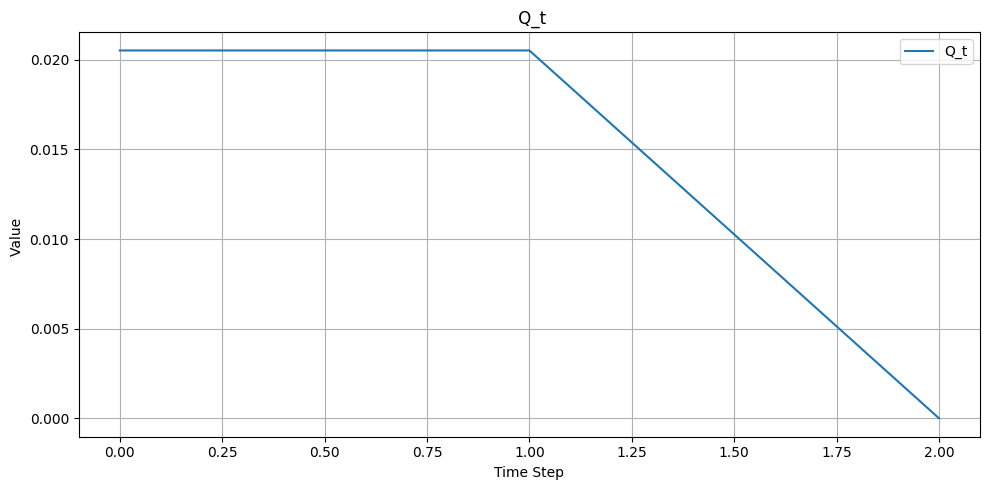

In [155]:
plt.figure(figsize=(10, 5))
plt.plot(Q_vals[650:653], label="Q_t")
plt.xlabel("Time Step")
plt.ylabel("Value ")
plt.title(" Q_t")

plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "Q_t_over_time.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


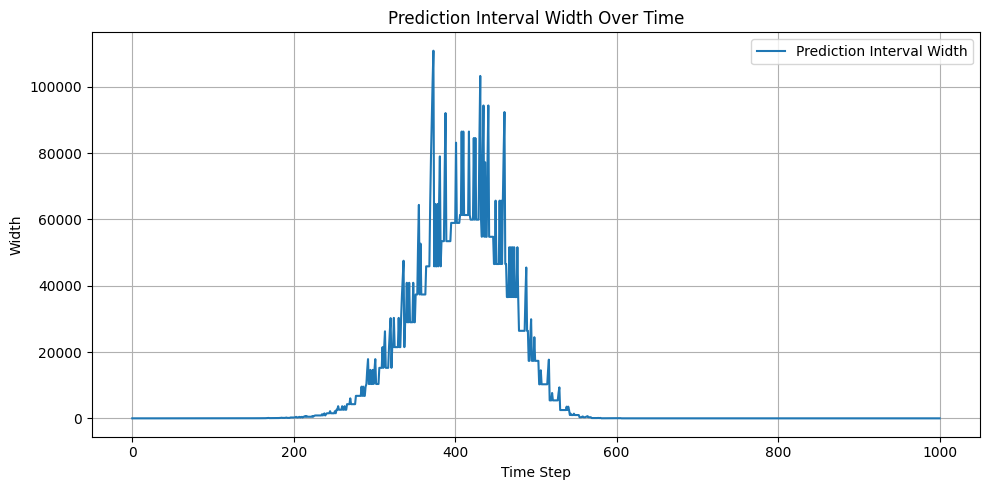

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(interval_widths_with_correction, label="Prediction Interval Width")
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.title("Prediction Interval Width Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig_name = "plot_interval_width.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

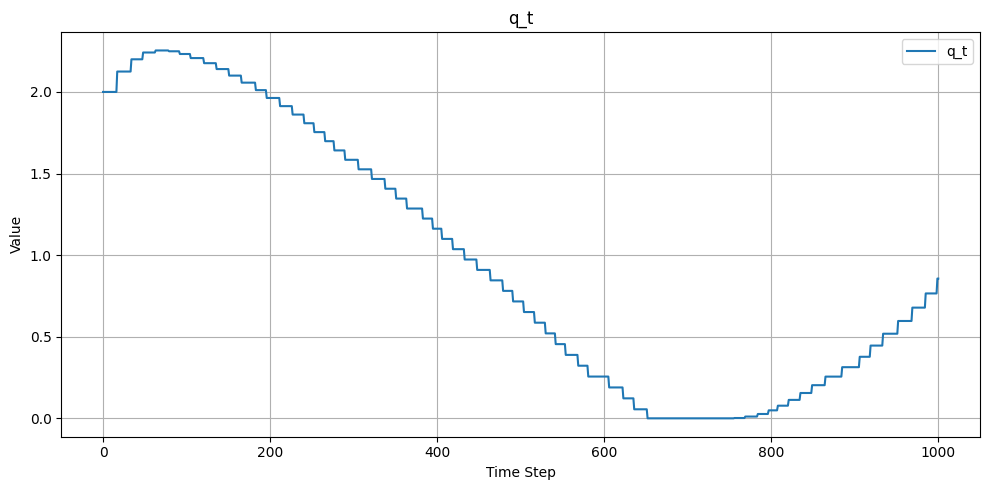

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(q_vals)), q_vals,  label="q_t")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("q_t")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "q_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

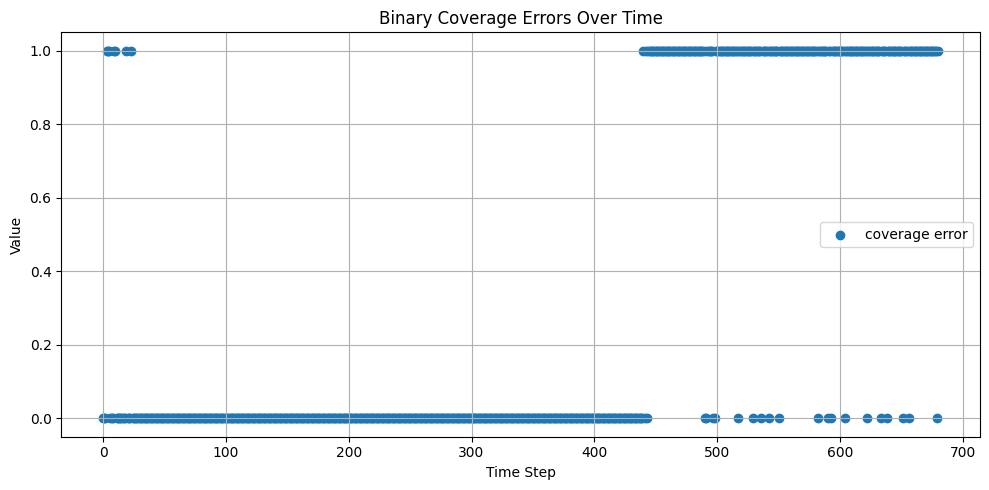

In [156]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E))  # or your actual time step data
plt.scatter(time_steps, E, label="coverage error")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "E_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300)
plt.show()

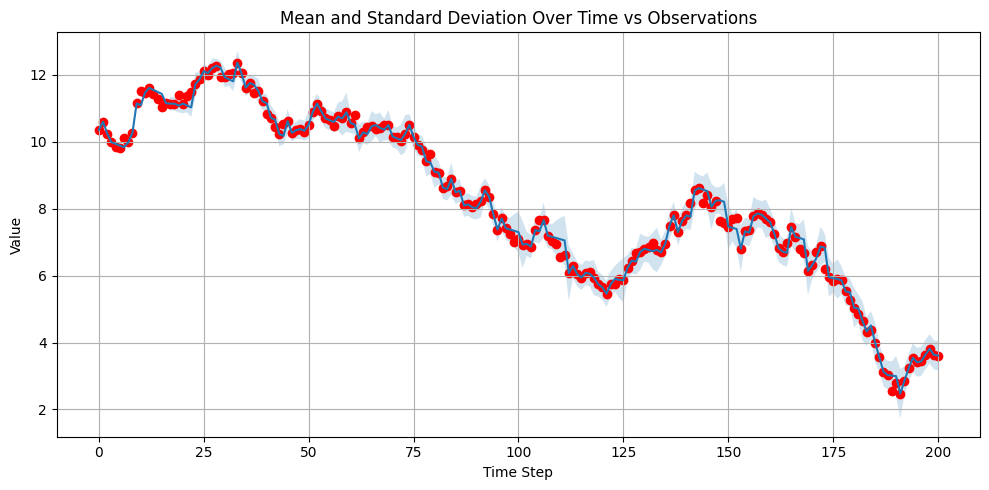

In [26]:
plt.figure(figsize=(10, 5))
ts = np.arange(len(meu)) 
plt.plot(ts, meu, label=" meu")
# plt.fill_between(ts, meu- std, meu + std, alpha=0.2, label="Confidence Interval")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Over Time vs Observations")
plt.grid(True)
plt.tight_layout()
plt.savefig("calibrated_distribution_over_time_vs_observation.png", dpi=300)
plt.fill_between(ts, meu - sigma, meu + sigma, alpha=0.2, label="Confidence Interval")
ts_new = np.arange(np.size(masked_observations))
# mask = ~np.isnan(masked_observations)
# ts_valid = ts_new[mask.flatten()]
# obs_valid = masked_observations[mask.flatten()]
# plt.scatter(ts_valid, obs_valid, color='red', label='Observations')
obs = data['observations']
plt.scatter(ts_new, obs, color='red', label='Observations')
plt.show()
